# Importance of Numerical Integration for Quants

Numerical optimization is a foundational tool in quantitative finance. It involves finding the best solution (maximum or minimum) to a problem under given constraints, often when analytical solutions are unavailable or impractical.

| Quant Role                  | Primary Use Case                          | Integration Purpose                                           | Example Application                                      |
|----------------------------|-------------------------------------------|---------------------------------------------------------------|----------------------------------------------------------|
| Derivatives Pricing Quants | Pricing exotic and structured derivatives | Evaluate expected payoffs under complex distributions         | Barrier option pricing via log-normal integration        |
| Risk Management Quants     | Estimating and managing financial risk    | Integrate over loss distributions to quantify tail risk       | Computing Expected Shortfall (CVaR) from loss PDF        |
| Quant Researchers           | Model development and calibration         | Solve SDEs, compute likelihoods, fit models to market data    | Calibrating Heston model using numerical quadrature      |
| Algorithmic Trading Quants | Designing statistical trading strategies  | Estimate expected returns and volatility from distributions   | Integrating return PDFs to compute Sharpe ratios         |
| Quant Developers            | Building pricing and risk infrastructure | Implement efficient numerical integration routines            | Coding adaptive quadrature modules for pricing engines   |


### Numerical quadrature for integration

We will start this notebook with the following example. $$f(x)=e^{-x^2}$$

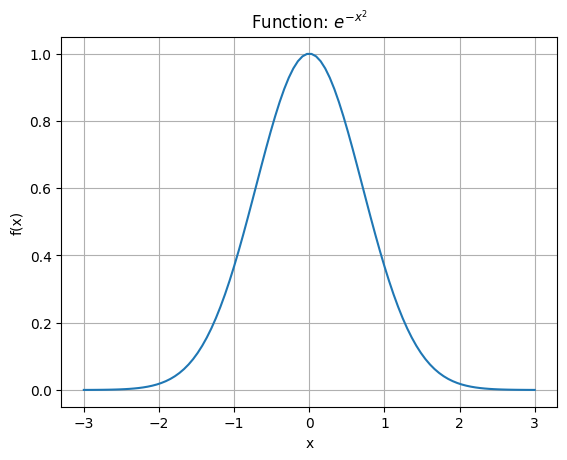

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define a sample function
def f(x):
    return np.exp(-x**2)

x = np.linspace(-3, 3, 100)
y = f(x)

plt.plot(x, y)
plt.title("Function: $e^{-x^2}$")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()

Let us now tackle the problem of computing $$\int_{-\infty}^\infty e^{-x^2}dx$$
numerically.
### A simple approach: the trapezoidal rule

From the definition of the Riemann integral we may approximmate 
$$\int_a^b f(x)dx\approx \sum_{i=1}^n \frac{f(x_{i-1})+f(x_i)}{2}\Delta x=\left(\frac{f(x_0)+f(x_N)}{2}+\sum_{i=1}^{n-1} +f(x_i)\right)\Delta x$$ for a suitable equidistant partition $x_0<x_1,...<x_n$ with $x_0=a$ and $x_n=b$ such that $x_{i+1}-x_i=\Delta x$.

**Note:** In the case where $a$ or $b$ is $\infty$ we have to truncate the numerical approximation.

In [13]:
def trapezoidal_rule(func, a, b, n):
    x = np.linspace(a, b, n+1)
    y = func(x)
    dx = (b - a) / n
    area = (y[0] + y[-1]) / 2 + np.sum(y[1:-1])
    return dx * area

manual_result = trapezoidal_rule(f, a=-5, b=5, n=1000)
print(f"Manual trapezoidal result: {manual_result:.6f}")

Manual trapezoidal result: 1.772454


### Scipy's Integration suite

As we have discussed, Scipy offers a large suite of numerical methods. We will now focus on the integration suite. The main function tha you will be using to perform a numerical integration is `scipy.integrate` https://docs.scipy.org/doc/scipy/tutorial/integrate.html

In particular, when performing 1D integration you will use `scipy.integrate.quad` https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad

In [12]:
from scipy.integrate import quad

# Integrate f(x) from -∞ to ∞
result, error = quad(f, -np.inf, np.inf)
print(f"Integral result: {result:.4f}, Estimated error: {error:.2e}")

Integral result: 1.7725, Estimated error: 1.42e-08


### A financial example with the Black Scholes model and a European Call option

As you will learn this year, the Black-Scholes model establishes that the dynamics of a stock price are given by (without interest rates or dividends)

$$S_t=S_0e^{\sigma W_t-\frac{\sigma^2t}{2}}\quad \text{with }W_t\sim\mathcal{N}(0,t) $$

A European Call option is a derivative with payoff given by:
$$(S_T-K)^+=(S_T-K)\mathcal{1}_{\{S_T>K\}}.$$

Using risk Neutral pricing we know that the fair price of a European call option $C(K,T)$ is given by
$$C(K,T)=\mathbb{E}[(S_T-K)^+]$$
Since the distribution of $S_T$ is known in the Black-Scholes model, we may easily translate this pricing problem into an integral representation i.e.

$$C(K,T)=\mathbb{E}[(S_T-K)^+]=\int_{-\infty}^\infty (S_0e^{\sigma x-\frac{\sigma^2T}{2}}-K)\mathcal{1}_{\{S_0e^{\sigma x-\frac{\sigma^2T}{2}}>K\}} \phi(x) dx $$
where $\phi(x)$ is the pdf of Gaussian rangom variable with variance $T$, .i.e.

$$\phi(x)=\frac{1}{\sqrt{2\pi T}}e^{-\frac{-x^2}{2T}}$$

In [23]:
def phi(x,T):
    return 1.0/np.sqrt(2*np.pi*T)*np.exp(-0.5/T*x**2)
def S_T(x,S0,sigma,T):
    return S0*np.exp(sigma*x-0.5*T*sigma**2)
def integrand(x,S0,sigma,T,K):
    return (S_T(x,S0,sigma,T)>K)*(S_T(x,S0,sigma,T)-K)*phi(x,T)

In [24]:
S0=100
K=100
sigma=0.2
T=1
result, error = quad(integrand, -np.inf, np.inf,args=(S0,sigma,T,K))
print(f"Integral result: {result:.4f}, Estimated error: {error:.2e}")

Integral result: 7.9656, Estimated error: 9.42e-08


We can cross-check the result against the Black-Scholes formula


### Call Option Price



$$
C = S_0 \cdot N(d_1) - K  \cdot N(d_2)
$$



Where:



$$
d_1 = \frac{\ln(S_0 / K) + ( \frac{1}{2} \sigma^2) T}{\sigma \sqrt{T}}, \quad
d_2 = d_1 - \sigma \sqrt{T}
$$



**Variables:**
- $ S_0 $: Current stock price
- $ K $: Strike price
- $ T $: Time to maturity (in years)
- $ \sigma $: Volatility
- $ N(\cdot) $: Cumulative distribution function of the standard normal distribution

In [28]:
from scipy.stats import norm

def black_scholes_call(S0, K, T, sigma):
    """
    Black-Scholes formula for European options.
    
    Parameters:
    S0 : float - initial stock price
    K : float - strike price
    T : float - time to maturity (in years)
    sigma : float - volatility
    
    Returns:
    float - option price
    """
    d1 = (np.log(S0 / K) + ( 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    price = S0 * norm.cdf(d1) - K  * norm.cdf(d2)
    
    return price

In [29]:
black_scholes_call(S0, K, T, sigma)

np.float64(7.965567455405804)